#  梯度提升树的参数

*class* `sklearn.ensemble.GradientBoostingClassifier`(*, loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

*class* `sklearn.ensemble.GradientBoostingRegressor`(*, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

与随机森林一样，由于GBDT超参数数量较多，因此我们可以将GBDT的参数分为以下5大类别，其中标注为绿色的参数包括了我们未曾学过的知识、需要重点讲解：

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：n_estimators, learning_rate, **<font color="green">loss, alpha, init</font>**<br>属性：<font color="green">**loss_, init_, estimators_**</font>|
|**弱评估器结构**|<font color="green">**criterion**</font>, max_depth, min_samples_split, min_samples_leaf, <br>min_weight_fraction_leaf, max_leaf_nodes,<br>min_impurity_decrease|
|**提前停止**|参数：<font color="green">**validation_fraction, n_iter_no_change, tol**</font><br>属性：<font color="green">**n_estimators_**</font>|
|**弱评估器的训练数据**|参数：subsample, max_features, random_state<br>属性：<font color="green">**oob_improvement, train_score_**</font>|
|**其他**|ccp_alpha, warm_start|

## 1 迭代过程

之前我们提到过，GBDT的整体建模流程与AdaBoost高度相似，因此GBDT当中也有设置具体迭代次数（弱评估器次数）的参数`n_estimators`与学习率参数`learning_rate`，这两个参数的含义、以及对集成算法的影响与AdaBoost当中完全一致。

具体地来说，对于样本$x_i$，集成算法当中一共有$T$棵树，则参数`n_estimators`的取值为T。假设现在正在建立第$t$个弱评估器，则则第$t$个弱评估器上$x_i$的结果可以表示为$f_t(x_i)$。假设整个Boosting算法对样本$x_i$输出的结果为$H(x_i)$，则该结果一般可以被表示为t=1~t=T过程当中，所有弱评估器结果的加权求和：

$$H(x_i) =  \sum_{t=1}^\
boldsymbol{\color{red}T}
\phi_tf_t(x_i)
$$

其中，$\phi_t$为第t棵树的权重。对于第$t$次迭代来说，则有：

$$H_t(x_i) = H_{t-1}(x_i) + \phi_tf_t(x_i)
$$

在这个一般过程中，每次将本轮建好的决策树加入之前的建树结果时，可以在权重$\phi$前面增加参数$\color{red}\eta$，表示为第t棵树加入整体集成算法时的学习率，对标参数`learning_rate`。

$$H_t(x_i) = H_{t-1}(x_i) + \boldsymbol{\color{red}\eta} \phi_tf_t(x_i)$$

该学习率参数控制Boosting集成过程中$H(x_i)$的增长速度，是相当关键的参数。当学习率很大时，$H(x_i)$增长得更快，我们所需的`n_estimators`更少，当学习率较小时，$H(x_i)$增长较慢，我们所需的`n_estimators`就更多，因此boosting算法往往会需要在`n_estimators`与`learning_rate`中做出权衡。

这两个参数的使用方法与AdaBoost中也完全一致，故此处不再赘述，后续我们会直接使用这两个参数进行调参。

### 1.1 初始预测结果$H_0$的设置

在上述过程中，我们建立第一个弱评估器时有：

$$H_1(x_i) = H_{0}(x_i) + \phi_1f_1(x_i)$$

由于没有第0棵树的存在，因此$H_0(x_i)$的值在数学过程及算法具体实现过程中都需要进行单独的确定，这一确定过程由参数`init`确定。

- 参数`init`：输入计算初始预测结果$H_0$的估计器对象。

在该参数中，可以输入任意评估器、字符串"zero"、或者None对象，默认为None对象。
> 当输入任意评估器时，评估器必须要具备fit以及predict_proba功能，即我们可以使用决策树、逻辑回归等可以输出概率的模型。如果输出一个已经训练过、且精细化调参后的模型，将会给GBDT树打下坚实的基础。<br><br>
> 填写为字符串"zero"，则代表令$H_0 = 0$来开始迭代。<br><br>
> 不填写，或填写为None对象，sklearn则会自动选择类`DummyEstimator`中的某种默认方式进行预测作为$H_0$的结果。`DummyEstimator`类是sklearn中设置的使用超简单规则进行预测的类，其中最常见的规则是直接从训练集标签中随机抽样出结果作为预测标签，也有选择众数作为预测标签等选项。

一般在GBDT类的使用过程中，我们不会主动调节参数`init`，但是当我们有足够的算力支持超参数搜索时，我们可以在`init`上进行选择。

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import seaborn as sns
import re, pip, conda
import time
import os

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate, KFold

data = pd.read_csv(r"D:\myJupyter\机器学习\datasets\House Price\train_encode.csv",index_col=0)

d:\Anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
#回归数据
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

#定义所需的交叉验证方式
cv = KFold(n_splits=5,shuffle=True,random_state=1412)

def RMSE(result,name):
    return abs(result[name].mean())

gbr = GBR(random_state=1412) #实例化
result_gbdt = cross_validate(gbr,X,y,cv=cv
                             ,scoring="neg_root_mean_squared_error" #负根均方误差
                             ,return_train_score=True
                             ,verbose=True
                             ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.2s remaining:   10.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished


In [3]:
from sklearn.tree import DecisionTreeRegressor as DTR

tree_reg = DTR(random_state=1412)
rf = RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=0
              ,random_state=1412, verbose=False, n_jobs=-1)

for init in [tree_reg,rf,"zero",None]:
    reg = GBR(init = init,random_state=1412)
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    result_reg = cross_validate(reg,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                                ,return_train_score=True
                                ,verbose=False
                                ,n_jobs=-1)
    print("\n")
    print(RMSE(result_reg,"train_score"))
    print(RMSE(result_reg,"test_score"))



0.0
42065.93924112058


5669.291478825804
27205.38818750095


13990.791639702458
28739.882050269225


13990.790813889864
28783.954343252786


不难发现，初始参数的具体输入会对模型的最终结果造成巨大影响，在init中输入训练好的模型会加重GBDT的过拟合，但同时也可能得到更好的测试集结果。我们甚至可以无限套娃，让init参数中输入被训练好的GBDT模型，当然，这样做的结果往往是过拟合被放大到无法挽回了。通常来说，我们还是会选择"zero"作为init的输入。

与参数`init`相对的属性就是`init_`，当模型被拟合完毕之后，我们可以使用该属性来返回输出$H_0$的评估器对象。

In [4]:
reg = GBR(init = None,random_state=1412)
reg.fit(X,y).init_ #返回sklearn中的玩具评估器DummyRegressor

DummyRegressor()

In [5]:
reg = GBR(init = rf,random_state=1412)
reg.fit(X,y).init_

RandomForestRegressor(max_depth=22, max_features=14, min_impurity_decrease=0,
                      n_estimators=89, n_jobs=-1, random_state=1412,
                      verbose=False)

当然，在init中的值是我们自己输入的值的情况下，属性`init_`略显鸡肋，但我们或许会预见需要该属性的具体场景，例如在建模过程中进行监控打印时、或在大量初始化模型中选择最佳初始化模型时。

### 1.2 使用回归器完成分类任务

GBDT与AdaBoost及随机森林的关键区别之一，是GBDT中所有的弱评估器都是回归树，因此在实际调用梯度提升树完成分类任务时，需要softmax函数或sigmoid函数对回归树输出的结果进行处理。因此，对于二分类情况来说，集成算法对样本$x_i$输出的结果为：

$$H(x_i) =  \sum_{t=1}^\
boldsymbol
{\color{red}T}
\phi_tf_t(x_i)$$

$$ p(\hat{y}_i = 1 |x_i) = \sigma(H(x_i))$$

其中$\sigma$是sigmoid函数，当$p(\hat{y}_i = 1 |x_i)$大于0.5时，样本$x_i$的预测类别为1，反之则为0。

而对多分类来说，情况就比较复杂了。在讲解AdaBoost时我们说明过，二分类当中我们只需求解一个概率$P(Y=1)$，因为$P(Y=0) = 1 - P(Y=1)$，因此$P(Y=1)$大于0.5时预测标签为1，否则预测标签为0。但在多分类当中，我们必须求解出所有标签类别所对应的概率，在所有这些概率当中，最大概率所对应的标签才是多分类的预测标签。GBDT对于多分类也只能输出集成算法回归结果$H(x_i)$，因此我们需要使用**softmax函数**帮助我们将回归值转化为概率，而**Softmax函数是接受K个连续型结果，并输出K个相对概率的函数**。

一般我们在使用softmax函数时，3分类问题则需要向softmax函数输入3个值，4分类问题则需要向softmax函数输入4个值，以此类推，最终softmax函数输出的是与输入值同等数量的相对概率，而多分类算法的预测标签是相对概率最高的类别。因此，在使用softmax函数前，我们需要准备好与类别数量相当的$H(x_i)$。

具体来说，当现在的问题是$K$分类、且每个类别为$[1,2,3...k]$时，我们则分别按照$y = 1, y = 2,...,y = k$进行建模，总共建立$K$棵树，每棵树输出的结果为：

$$H^1(x_i), H^2(x_i),...,H^k(x_i)$$

总共$K$个输出结果。然后，我们分别将$H^1(x_i)$到$H^k(x_i)$的结果输入softmax，来计算出每个标签类别所对应的概率。具体地来说，softmax函数的表达式为：

$$Softmax(H^k(x)) = \frac{e^{H^k(x)}}{\sum_{k=1}^Ke^{H_k(x)}}$$

其中$e$为自然常数，$H$是集成算法的输出结果，$K$表示标签中的类别总数为$K$，如三分类时$K=3$，四分类时$K=4$，$k$表示任意标签类别，$H_k$则表示以类别$k$为真实标签进行训练而得出的$H$。不难发现，Softmax函数的分子时多分类状况下**某一个标签类别的H(x)的指数函数**，而分母时多分类状况下**所有标签类别的H(x)的指数函数之和**，因此Softmax函数的结果代表了样本的预测标签为类别$k$的概率。假设现在是三分类[1,2,3]，则样本$i$被分类为1类的概率为：

$$
\begin{aligned}
p^1(x_i) &= \frac{e^{H^1(x)}}{\sum_{k=1}^Ke^{H_k(x)}} \\
&= \frac{e^{H^1(x)}}{e^{H^1(x)}+e^{H^2(x)}+e^{H^3(x)}}\\
\end{aligned}$$

最终得到$K$个相对概率$p^k(x_i)$，并求解出相对概率最高的类别。不难发现，当执行多分类时，这一计算流程中涉及到的计算量以及弱评估器数量都会远远超出二分类以及回归类问题。实际上，在执行多分类任务时，如果我们要求模型迭代10次，模型则会按照实际的多分类标签数n_classes建立10 * n_classes个弱评估器。对于这一现象，我们可以通过属性`n_estimators_`以及属性`estimators_`查看到。

- `n_estimators_`：实际迭代次数，`estimators_`：实际建立的弱评估器数量

In [6]:
clf = GBC(n_estimators=10 #迭代次数为10次
          ,random_state=1412)

In [8]:
#分类数据
X_clf = data.iloc[:,:-2]
y_clf = data.iloc[:,-2]
X_clf.shape #查看X与y的结果

(1460, 79)

In [9]:
np.unique(y_clf) #6分类

array([0., 1., 2., 3., 4., 5.])

In [ ]:
clf = clf.fit(X_clf,y_clf)

In [ ]:
clf.n_estimators_ #实际迭代数量为10

10

In [ ]:
clf.estimators_.shape #但每次迭代时其实建立了6个评估器

(10, 6)

In [ ]:
clf.estimators_[0] #其中一次迭代中建立的全部评估器

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x204E8C6B140),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x204E8C6B140),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x204E8C6B140),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x204E8C6B140),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x204E8C6B140),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x204E8C6B140)],
      dtype=object)

- 如果是二分类则不会出现这种现象

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
X_clf2 = load_breast_cancer().data
y_clf2 = load_breast_cancer().target

In [ ]:
np.unique(y_clf2)

array([0, 1])

In [ ]:
clf = GBC(n_estimators=10,random_state=1412)
clf = clf.fit(X_clf2,y_clf2)

In [ ]:
clf.n_estimators_

10

In [ ]:
clf.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x204E9485840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x204E9485840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x204E9485840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x204E9485840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x204E9485840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x204E9485840)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
             

这一现象只在弱评估器为回归器的各类boosting算法中出现，对于弱评估器可以是回归树也可以是分类树的随机森林、Adaboost来说，多分类时每个类别对应的概率是在叶子节点上自然生成的。因为有此区别，因此多分类问题在随机森林上的计算可能会表现得更快。

### 1.3 GBDT的8种损失函数

作为基于AdaBoost改进的Boosting算法，GBDT的功绩之一是将损失函数从有限的指数损失、MSE等推广到了任意可微函数，因此GBDT的损失函数选择异常丰富，因此我们可以在调参时加入损失函数作为需要调整的参数进行考量。在sklearn中，控制具体损失函数的参数为`loss`。

GBDT中的损失函数因GBDT具体执行的预测任务而存在区别，同时也因标签的分布而存在区别。对于梯度提升分类树来说，loss的备选项有如下几种：

- 分类器中的`loss`：字符串型，可输入"deviance", "exponential"，默认值="deviance"

其中"deviance"直译为偏差，特指逻辑回归的损失函数——交叉熵损失，而"exponential"则特指AdaBoost中使用的指数损失函数。对任意样本$i$而言，$y_i$为真实标签，$\hat{y_i}$为预测标签，$H(x_i)$为集成算法输出结果，$p(x_i)$为基于$H(x_i)$和sigmoid/softmax函数计算的概率值。则各个损失的表达式为：

**二分类交叉熵损失**——<br><br>
$$L = -\left( y\log p(x) + (1 - y)\log(1 - p(x)) \right)$$

<br>注意，log当中输入的一定是概率值。对于逻辑回归来说，概率就是算法的输出，因此我们可以认为逻辑回归中$p = H(x)$，但对于GBDT来说，$p(x_i) = Sigmoid(H(x_i))$，这一点一定要注意。

<br>

**多分类交叉熵损失**，总共有K个类别——<br><br>

$$L = -\sum_{k=1}^Ky^*_k\log(P^k(x))$$

其中，$P^k(x)$是概率值，对于多分类GBDT来说，$p^k(x) = Softmax(H^k(x))$。$y^*$是由真实标签转化后的向量。例如，在3分类情况下，真实标签$y_i$为2时，$y^*$为[$y^*_{1}$,$y^*_{2}$,$y^*_{3}$]，取值分别为：

|$y^*_{1}$|$y^*_{2}$|$y^*_{3}$|
|:-:|:-:|:-:|
|$0$|$1$|$0$|

这一转化过程与AdaBoost中多分类指数损失中的转化高度相似。

**二分类指数损失**——<br><br>
$$L = e^{-yH(x)}
$$<br>

**多分类指数损失**，总共有K个类别——<br><br>

$$
\begin{aligned}
L &=exp \left( -\frac{1}{K}\boldsymbol{y^* · H^*(x)} \right) \\ 
& = exp \left( -\frac{1}{K}(y^1H^1(x)+y^2H^2(x) \ + \  ... + y^kH^k(x)) \right)
\end{aligned}
$$<br>

需要注意，指数损失中的$y^*$与交叉熵损失中的$y^*$不是同样的向量。我们已经在逻辑回归的章节中详解过交叉熵损失，在AdaBoost的章节当中详解过指数损失，因此这里便不再展开赘述了。需要注意的是，一般梯度提升分类器默认使用交叉熵损失，如果使用指数损失，则相当于执行没有权重调整的AdaBoost算法。

对于梯度提升回归树来说，loss的备选项有如下几种：

- 回归器中的`loss`：字符串型，可输入{"squared_error", "absolute_error", "huber", "quantile"}，默认值="squared_error"

其中'squared_error'是指回归的平方误差，'absolute_error'指的是回归的绝对误差，这是一个鲁棒的损失函数。'huber'是以上两者的结合。'quantile'则表示使用分位数回归中的弹球损失pinball_loss。对任意样本$i$而言，$y_i$为真实标签，$H(x_i)$为预测标签，则各个损失的表达式为：

**平方误差**——<br><br>

$$L = \sum{(y_i - H(x_i))^2}$$

<br>

**绝对误差**——<br><br>

$$L = \sum{|y_i - H(x_i)|}$$

<br>

**Huber损失**——

$$L = \sum{l(y_i,H(x_i))}$$

其中$$l = \begin{split} 
\begin{cases}\frac{1}{2}(y_i - H(x_i))^2, & |y_i - H(x_i)|\leq\alpha \\
\alpha(|y_i - H(x_i)|-\frac{\alpha}{2}),& |y_i - H(x_i)|>\alpha \end{cases}\end{split}, \space \space \alpha \in (0, 1)$$

<br>

**quantile损失**——

$$L = \sum{l(y_i,H(x_i))}$$

其中$$l = \begin{split} 
\begin{cases}
    \alpha (y_i - H(x_i)), & y_i - H(x_i) > 0 \\
    0,    & y_i - H(x_i) = 0 \\
    (1-\alpha) (y_i - H(x_i)), & y_i - H(x_i) < 0
\end{cases}\end{split}, \space \space \alpha \in (0, 1)$$

其中$\alpha$是需要我们自己设置的超参数，由参数`alpha`控制。在huber损失中，alpha是阈值，在quantile损失中，alpha用于辅助计算损失函数的输出结果，默认为0.9。

**<font color=red>===更新警告===</font>**<br>
在sklearn1.0版本及后续版本当中，损失函数"ls"与"lad"被删除了，其中"ls"的功能被"squared_error"取代，而"lad"被"absolute_error"取代。如果你在运行代码时，发现你的参数默认值、参数名称与课件中不相同，或者在运行过程中出现报错、警告等现象，你可能需要更新你的sklearn。

In [ ]:
对于相同的样本、相同的差异，不同损失函数给出的损失值不同

In [ ]:
yi = 10
Hx = 8

In [ ]:
绝对 - 2
平方 - 4 - 差异>1，误差被放大，差异<1，误差是会被缩小

- 如何选择不同的损失函数？

GBDT是工业应用最广泛的模型，工业数据大部分都极度偏态、具有长尾，因此GBDT必须考虑**离群值**带来的影响。数据中的离群值会极大程度地影响模型地构建，当离群值在标签当中、而我们是依赖于减小损失函数来逐渐构建算法时，这种影响会前所未有地大。**因此Boosting是天生更容易被离群值影响的模型、也更擅长学习离群值的模型。**<br><br>
![](https://discourse-cloud-file-uploads.s3.dualstack.us-west-2.amazonaws.com/business6/uploads/analyticsvidhya/original/1X/c3af040fef3ddc8f2bb1b393d71700e9a638426e.PNG)
![](https://discourse-cloud-file-uploads.s3.dualstack.us-west-2.amazonaws.com/business6/uploads/analyticsvidhya/original/1X/f3c5885defae011dd385462f1f3812ff24393105.PNG)

举例来说，若离群值的标签为1000，大部分正常样本的标签在0.1~0.2之间，算法一定会异常努力地学习离群值的规律，因为将离群值预测错误会带来巨大的损失。在这种状况下，最终迭代出的算法可能是严重偏离大部分数据的规律的。同样，我们也会遇见很多离群值对我们很关键的业务场景：例如，电商中的金额离群用户可能是VIP用户，风控中信用分离群的用户可能是高风险用户，这种状况下我们反而更关注将离群值预测正确。不同的损失函数可以帮助我们解决不同的问题——

- **当高度关注离群值、并且希望努力将离群值预测正确时，选择平方误差**<br><br>
这在工业中是大部分的情况。在实际进行预测时，离群值往往比较难以预测，因此离群样本的预测值和真实值之间的差异一般会较大。MSE作为预测值和真实值差值的平方，会放大离群值的影响，会让算法更加向学习离群值的方向进化，这可以帮助算法更好地预测离群值。

- **努力排除离群值的影响、更关注非离群值的时候，选择绝对误差**<br><br>
MAE对一切样本都一视同仁，对所有的差异都只求绝对值，因此会保留样本差异最原始的状态。相比其MSE，MAE对离群值完全不敏感，这可以有效地降低GBDT在离群值上的注意力。

- **试图平衡离群值与非离群值、没有偏好时，选择Huber或者Quantileloss**<br><br>
Huberloss损失结合了MSE与MAE，在Huber的公式中，当预测值与真实值的差异大于阈值时，则取绝对值，小于阈值时，则取平方。在真实数据中，部分离群值的差异会大于阈值，部分离群值的差异会小于阈值，因此比起全部取绝对值的MAE，Huberloss会将部分离群值的真实预测差异求平方，相当于放大了离群值的影响（但这种影响又不像在MSE那样大）。因此HuberLoss是位于MSE和MAE之间的、对离群值相对不敏感的损失。

- 属性`loss_`

In [ ]:
reg = GBR(n_estimators=10,random_state=1412).fit(X,y)

In [ ]:
reg.loss_ #返回具体的损失函数对象，而不会返回公式

总结一下，在整个迭代过程中，我们涉及到了如下参数及属性：

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：<br><br>&emsp;n_estimators：集成算法中弱评估器数量，对Boosting算法而言为实际迭代次数<br><br>&emsp;learning_rate：Boosting算法中的学习率，影响弱评估器结果的加权求和过程<br><br>&emsp;<font color="green">**loss, alpha**</font>：需要优化的损失函数，以及特定损失函数需要调节的阈值<br><br>&emsp;<font color="green">**init**</font>：初始化预测结果$H_0$的设置<br><br>属性：<br><br>&emsp;<font color="green">**loss_**</font>：返回具体的损失函数对象<br><br>&emsp;<font color="green">**init_**</font>：返回具体的初始化设置<br><br>&emsp;<font color="green">**estimators_**</font>：返回实际建立的评估器列表<br><br>&emsp;n_estimators_：返回实际迭代次数|

## 2 弱评估器结构

在讲解决策树时，我们已经系统地讲解过弱评估器相关的一系列减枝参数，而在讲解随机森林时，我们又明确了这些减枝参数如何影响集成算法。因此我们对于Boosting算法中控制弱评估器的参数可谓非常熟悉：

|类型|参数|
|----|----|
|**弱评估器结构**|<font color="green">**criterion**</font>：弱评估器分枝时的不纯度衡量指标<br><br>max_depth：弱评估器被允许的最大深度，默认3<br><br>min_samples_split：弱评估器分枝时，父节点上最少要拥有的样本个数<br><br>min_samples_leaf：弱评估器的叶子节点上最少要拥有的样本个数<br><br>min_weight_fraction_leaf：当样本权重被调整时，叶子节点上最少要拥有的样本权重<br><br>max_leaf_nodes：弱评估器上最多可以有的叶子节点数量<br><br>min_impurity_decrease：弱评估器分枝时允许的最小不纯度下降量|

这些参数在随机森林中的**用法与默认值**与决策树类`DecisionTreeRegressor`中完全一致，专门用于对决策树进行剪枝、控制单个弱评估器的结构，考虑到大家在决策树中已经充分掌握这些参数，我们不再对这些参数一一进行详细说明了。在这里，需要重点说明的有两部分内容，一部分梯度提升树中默认的弱评估器复杂度所带来的问题，另一部分则是梯度提升树独有的不纯度衡量指标。

### 2.1 梯度提升树中的弱评估器复杂度

- `max_depth`

虽然我们非常熟悉控制弱评估器结构的各个参数，但在实际应用任意Boosting算法时，我们还需进一步了解算法在这些参数上的默认值，以了解该算法留给我们的调参余地是否较大。

在随机森林中我们讲到，森林中任意控制过拟合的参数基本都处于“关闭状态”，例如`max_depth`的默认值为None，表示不限深度，`min_samples_splits`的默认值为2，等同于不限制分枝，因此随机森林中长出的树都是剪枝前的树，也因此当随机森林算法处于过拟合状态时，我们可以使用粗或精的方法对弱评估器进行大刀阔斧的剪枝，当随机森林中的树被剪掉之后，可以很好的限制过拟合。然而这种情况并不适用于任何集成算法，尤其是以AdaBoost为基础的Boosting算法一族。

在原始AdaBoost理论中，AdaBoost中使用的弱分类器都是最大深度为1的树桩或最大深度为3的小树苗，因此基于AdaBoost改进的其他Boosting算法也有该限制，即默认弱评估器的最大深度一般是一个较小的数字。**对GBDT来说，无论是分类器还是回归器，默认的弱评估器最大深度都为3**，因此GBDT默认就对弱评估器有强力的剪枝机制。

当随机森林处于过拟合状态时，还可通过降低弱评估器复杂度的手段控制过拟合，但GBDT等Boosting算法处于过拟合状态时，便只能从数据上下手控制过拟合了（例如，使用参数`max_features`，在GBDT中其默认值为None），毕竟当`max_depth`已经非常小时，其他精剪枝的参数如`min_impurity_decrease`一般发挥不了太大的作用。

也因此，通常认为Boosting算法比Bagging算法更不容易过拟合，一般在相似的数据上，Boosting算法表现出的过拟合程度会较轻。

### 2.2 弗里德曼均方误差

- 不纯度衡量指标`criterion`

criterion是树分枝时所使用的不纯度衡量指标。在sklearn当中，GBDT中的弱学习器$f$是CART树，因此每棵树在建立时都依赖于CART树分枝的规则进行建立。CART树每次在分枝时都只会分为两个叶子节点（二叉树），它们被称为左节点(left)和右节点(right)。在CART树中进行分枝时，我们需要找到令左右节点的不纯度之和最小的分枝方式。**通常来说，我们求解父节点的不纯度与左右节点不纯度之和之间的差值，这个差值被称为不纯度下降量**(impurity decrease)。不纯度的下降量越大，该分枝对于降低不纯度的贡献越大。

对GBDT来说，不纯度的衡量指标有2个：弗里德曼均方误差friedman_mse与平方误差squared_error。其中平方误差我们非常熟悉，弗里德曼均方误差是由Friedman在论文《贪婪函数估计：一种梯度提升机器》（GREEDY FUNCTION APPROXIMATION: 
A GRADIENT BOOSTING MACHINE）中提出的全新的误差计算方式。遗憾的是，在论文当中，Friedman并没有提供弗里德曼均方误差的公式本身，而只提供了使用弗里德曼均方误差之后推导出的不纯度下降量的公式。该公式如下：

**<center>基于弗里德曼均方误差的不纯度下降量</center>**<br>

$$\frac{w_lw_r}{w_l \space + \space w_r} * \left( \frac{\sum_l{(r_i - \hat{y_i})^2}}{w_l} - \frac{\sum_r{(r_i - \hat{y_i})^2}}{w_r}\right)^2$$

<br>

其中$w$是左右叶子节点上的样本量，当我们对样本有权重调整时，$w$则是叶子节点上的样本权重。$r_i$大多数时候是样本i上的残差（父节点中样本i的预测结果与样本i的真实标签之差），也可能是其他衡量预测与真实标签差异的指标，$\hat{y_i}$是样本i在当前子节点下的预测值。所以这个公式其实可以解读成：

**<center>左右叶子节点上样本量的调和平均 * (左叶子节点上均方误差 - 右叶子节点上的均方误差)^2</center>**

根据论文中的描述，弗里德曼均方误差使用调和平均数（分子上相乘分母上相加）来控制左右叶子节点上的样本数量，相比普通地求均值，调和平均必须在左右叶子节点上的样本量/样本权重相差不大的情况下才能取得较大的值（F1 score也是用同样的方式来调节Precision和recall）。这种方式可以令不纯度的下降得更快，让整体分枝的效率更高。

同时，在决策树进行分枝时，一般不太可能直接将所有样本分成两个不纯度非常低的子集（分别位于两片叶子上），相对的，树会偏向于建立一个不纯度非常非常低的子集，然后将剩下无法归入这个低不纯度子集的样本全部打包成另外一个子集。因此直接使用两个子集之间的MSE差距来衡量不纯度的下降量非常聪明，如果两个子集之间的MSE差异很大，则说明其中一个子集的MSE一定很小，对整体分枝来说是更有利的。同样非常遗憾的是，Friedman并没有在为我们提供完整数学证明，以佐证刚才所说的观点。

除了Friedman_mse之外，我们也可以使用普通的平方误差作为不纯度的衡量。使用普通平方误差时，我们可以直接计算父节点的平方误差与子节点平方误差的加权求和之间的差异。

**<center>平方误差的不纯度下降量</center>**

$$\frac{\sum_p{(r_i - \hat{y_i})^2}}{w_l + w_r} - (\frac{w_l}{w_l+w_r} * \sum_l{(r_i - \hat{y_i})^2} + \frac{w_r}{w_l+w_r} * \sum_r{(r_i - \hat{y_i})^2})
$$<br>

**大部分时候，使用弗里德曼均方误差可以让梯度提升树得到很好的结果**，因此GBDT的默认参数就是Friedman_mse。不过许多时候，我们会发现基于平方误差的分割与基于弗里德曼均方误差的分割会得到相同的结果。

## 3 梯度提升树的提前停止

在学习机器学习理论与方法时，我们极少提及迭代的提前停止问题。在机器学习中，依赖于迭代进行工作的算法并不算多，同时课程中的数据量往往也比较小，因此难以预见需要提前停止迭代以节省计算资源或时间的情况。但对于工业界使用最广泛的GBDT而言，提前停止是需要考虑的关键问题。

对于任意需要迭代的算法，迭代的背后往往是损失函数的最优化问题。例如在逻辑回归中，我们在进行梯度下降的迭代时，是希望找到交叉熵损失函数的最小值；而在梯度提升树中，我们在一轮轮建立弱评估器过程中，也是希望找到对应损失函数的最小值。理想状态下，无论使用什么算法，只要我们能够找到损失函数上真正的最小值，那**模型就达到“收敛”状态，迭代就应该被停止**。

然而遗憾的是，我们和算法都不知道损失函数真正的最小值是多少，而算法更不会在达到收敛状态时就自然停止。在机器学习训练流程中，我们往往是通过给出一个极限资源来控制算法的停止，比如，我们通过超参数设置允许某个算法迭代的最大次数，或者允许建立的弱评估器的个数。因此无论算法是否在很短时间内就锁定了足够接近理论最小值的次小值、或者算法早已陷入了过拟合状态、甚至学习率太低导致算法无法收敛，大多数算法都会持续（且无效地）迭代下去，直到我们给与的极限资源全部被耗尽。对于复杂度较高、数据量较大的Boosting集成算法来说，无效的迭代常常发生，因此作为众多Boosting算法的根基算法，梯度提升树自带了提前停止的相关超参数。另外，逻辑回归看起来会自然停止，是因为逻辑回归内置提前停止机制。

我们根据以下原则来帮助梯度提升树实现提前停止：

- **当GBDT已经达到了足够好的效果（非常接近收敛状态），持续迭代下去不会有助于提升算法表现**
- **GBDT还没有达到足够好的效果（没有接近收敛），但迭代过程中呈现出越迭代算法表现越糟糕的情况**
- **虽然GBDT还没有达到足够好的效果，但是训练时间太长/速度太慢，我们需要重新调整训练**

第三种情况可以通过参数verbose打印结果来观察，如果GBDT的训练时间超过半个小时，建树平均时长超出1分钟，我们就可以打断训练考虑重调参数。前两种情况则比较复杂，我们首先必须理解什么叫做“足够好的效果”。在GBDT迭代过程中，只要损失函数的值持续减小、或验证集上的分数持续上升，我们就可以认为GBDT的效果还有提升空间。在实际训练过程中，刚开始训练时，测试集和训练集上的损失一般都很高（有时，训练集上的损失甚至比测试集上的损失还高，这说明模型严重欠训练），但随着训练次数的增多，两种损失都会开始快速下降，一般训练集下降得更快，测试集下降得缓慢。直到某一次迭代时，无论我们如何训练，测试集上的损失都不再下降，甚至开始升高，此时我们就需要让迭代停下。

如下图所示，下图中横坐标为迭代次数，纵坐标为损失函数的值。当测试集上的损失不再下降、持续保持平稳时，满足条件1，继续训练会浪费训练资源，迭代下去模型也会停滞不前，因此需要停止（左图）。当测试集上的损失开始升高时，往往训练集上的损失还是在稳步下降，继续迭代下去就会造成训练集损失比测试集损失小很多的情况，也就是过拟合（右侧），此时满足条件2，也需要提前停止。在过拟合之前及时停止，能够防止模型被迭代到过拟合状况下。

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021MachineLearning/Ensembles/Public/53.PNG)

在实际数据训练时，我们往往不能动用真正的测试集进行提前停止的验证，因此我们需要从训练集中划分出一小部分数据，专用于验证是否应该提前停止。那我们如何找到这个验证集损失不再下降、准确率不再上升的“某一时间点”呢？此时，我们可以规定一个阈值，例如，**当连续`n_iter_no_change`次迭代中，验证集上损失函数的减小值都低于阈值`tol`，或者验证集的分数提升值都低于阈值`tol`的时候，我们就令迭代停止**。此时，即便我们规定的`n_estimators`或者`max_iter`中的数量还没有被用完，我们也可以认为算法已经非常接近“收敛”而将训练停下。这种机制就是提前停止机制Early Stopping。这种机制中，需要设置阈值`tol`，用于不断检验损失函数下降量的验证集，以及损失函数连续停止下降的迭代轮数`n_iter_no_change`。在GBDT当中，这个流程刚好由以下三个参数控制：

- `validation_fraction`：从训练集中提取出、用于提前停止的验证数据占比，值域为[0,1]。
- `n_iter_no_change`：当验证集上的损失函数值连续n_iter_no_change次没有下降或下降量不达阈值时，则触发提前停止。平时则设置为None，表示不进行提前停止。
- `tol`：损失函数下降的阈值，默认值为1e-4，也可调整为其他浮点数来观察提前停止的情况。

需要注意的是，当提前停止条件被触发后，梯度提升树会停止训练，即停止建树。因此，当提前停止功能被设置打开时，我们使用属性`n_estimators_`调出的结果很可能不足我们设置的`n_estimators`，属性`estimators_`中的树数量也可能变得更少：

In [ ]:
reg1 = GBR(n_estimators=100
          ,validation_fraction=0.1,n_iter_no_change=10,tol=0.01
          ,random_state=1412,verbose=True).fit(X,y)


      Iter       Train Loss   Remaining Time 
         1  5514149069.3942            0.59s
         2  4757494791.3091            0.93s
         3  4135611877.1608            0.90s
         4  3617733865.9522            0.81s
         5  3181720508.2060            0.79s
         6  2815131775.8119            0.76s
         7  2507962392.4188            0.73s
         8  2238966663.4425            0.69s
         9  2009699424.2492            0.67s
        10  1814955565.7236            0.67s
        20   822068581.4203            0.52s
        30   509402412.7933            0.44s
        40   386179875.0618            0.51s
        50   321922360.8108            0.43s
        60   283265211.0252            0.37s
        70   255541395.6525            0.27s
        80   231234309.1592            0.18s
        90   210609110.6698            0.09s


In [ ]:
reg2 = GBR(n_estimators=100,random_state=1412,verbose=True).fit(X,y)

      Iter       Train Loss   Remaining Time 
         1  5414666697.2413            0.59s
         2  4691239369.7631            0.78s
         3  4086315332.5980            0.77s
         4  3579387985.7262            0.79s
         5  3153929839.6306            0.78s
         6  2792392551.1292            0.73s
         7  2497130392.1365            0.72s
         8  2238910590.0126            0.69s
         9  2017698809.4694            0.66s
        10  1816369982.8554            0.64s
        20   832375488.7016            0.52s
        30   534539118.3102            0.45s
        40   407622352.5644            0.38s
        50   341113313.8828            0.33s
        60   301354860.3006            0.28s
        70   274573946.5769            0.20s
        80   252246253.6291            0.13s
        90   235659790.9783            0.07s
       100   219637782.6059            0.00s


In [ ]:
reg1.n_estimators_ #打开提前停止

93

In [ ]:
reg2.n_estimators_ #关闭提前停止

100

- 提前停止pk不提前停止

In [ ]:
import time
from sklearn.model_selection import train_test_split

In [ ]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

In [ ]:
start = time.time()
reg1 = GBR(n_estimators=1000
          ,validation_fraction=0.2,n_iter_no_change=10,tol=0.001
          ,random_state=1412).fit(Xtrain,Ytrain)
print(time.time()-start)

0.5076413154602051


In [ ]:
start = time.time()
reg2 = GBR(n_estimators=1000,random_state=1412).fit(Xtrain,Ytrain)
print(time.time()-start)

4.888045787811279


In [ ]:
reg1.n_estimators_ #打开提前停止

109

In [ ]:
reg2.n_estimators_ #关闭提前停止

1000

In [ ]:
reg1.score(Xtest,Ytest) #R2

0.897711170231429

In [ ]:
reg2.score(Xtest,Ytest)

0.89927123751538

什么时候使用提前停止呢？一般有以下几种场景：

- 当数据量非常大，肉眼可见训练速度会非常缓慢的时候，开启提前停止以节约运算时间<br><br>
- n_estimators参数范围极广、可能涉及到需要500~1000棵树时，开启提前停止来寻找可能的更小的n_estimators取值<br><br>
- 当数据量非常小，模型很可能快速陷入过拟合状况时，开启提前停止来防止过拟合<br>

总结：

|类型|参数|
|----|----|
|**提前停止**|<font color="green">**validation_fraction**</font>：从训练集中提取出、用于提前停止的验证数据占比<br><br><font color="green">**n_iter_no_change**</font>：当验证集上的损失函数值连续n_iter_no_change次没有下降<br>或下降量不达阈值时，则触发提前停止<br><br><font color="green">**tol**</font>：损失函数下降量的最小阈值|

## 4 梯度提升树的袋外数据

在讲解梯度提升树的基本原理时，我们提到梯度提升树结合了Boosting和Bagging中的重要思想。受到随机森林的启发，梯度提升树在每次建树之前，也允许模型对于数据和特征进行随机有放回抽样，构建与原始数据集相同数据量的自助集。在梯度提升树的原理当中，当每次建树之前进行随机抽样时，这种梯度提升树叫做随机提升树（Stochastic Gradient Boosting）。相比起传统的梯度提升树，随机提升树输出的结果往往方差更低，但偏差略高。如果我们发现GBDT的结果高度不稳定，则可以尝试使用随机提升树。

在GBDT当中，对数据的随机有放回抽样比例由参数`subsample`确定，当该参数被设置为1时，则不进行抽样，直接使用全部数据集进行训练。当该参数被设置为(0,1)之间的数字时，则使用随机提升树，在每轮建树之前对样本进行抽样。对特征的有放回抽样比例由参数`max_features`确定，随机模式则由参数`random_state`确定，这两个参数在GBDT当中的使用规则都与随机森林中完全一致。

需要注意的是，如果`subsample`<1，即存在有放回随机抽样时，当数据量足够大、抽样次数足够多时，大约会有37%的数据被遗漏在“袋外”（out of bag）没有参与训练。在随机森林课程当中，我们详细地证明了37%的由来，并且使用这37%的袋外数据作为验证数据，对随机森林的结果进行验证。在GBDT当中，当有放回随机抽样发生时，自然也存在部分袋外数据没有参与训练。这部分数据在GBDT中被用于对每一个弱评估器的建立结果进行验证。

具体地来说，**每建立一棵树，GBDT就会使用当前树的袋外数据对建立新树后的模型进行验证，以此来对比新建弱评估器后模型整体的水平是否提高，并保留提升或下降的结果**。这个过程相当于在GBDT迭代时，不断检验损失函数的值并捕捉其变化的趋势。在GBDT当中，这些袋外分数的变化值被储存在属性`oob_improvement_`中，同时，GBDT还会在每棵树的训练数据上保留袋内分数（in-bag）的变化，且储存在属性`train_score_`当中。也就是说，即便在不做交叉验证的情况下，我们也可以简单地通过属性`oob_improvement`与属性`train_score_`来观察GBDT迭代的结果。我们来看具体的例子：

In [ ]:
reg = GBR(n_estimators=500,learning_rate=0.1
          ,subsample=0.3 #每次建树只抽取30%的数据进行训练
          ,random_state=1412).fit(X,y)

In [ ]:
reg.oob_improvement_.shape #袋外数据上的损失函数变化量

(500,)

In [ ]:
reg.train_score_.shape #训练集上的损失函数变化量

(500,)

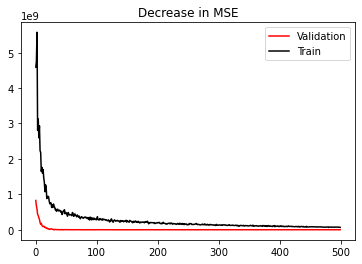

In [ ]:
plt.plot(range(500),reg.oob_improvement_,color="red",label="Validation")
plt.plot(range(500),reg.train_score_,color="k",label="Train")
plt.title("Decrease in MSE")
plt.legend();

不难发现，随着迭代次数的增加，训练集上的损失函数一直有下降量，虽然下降量在逐渐变小，但是损失函数的确是在持续减下降的，相对的，验证集上的结果则在少有波动之后就维持在0附近不动了，也就是说模型的泛化能力在很早的时候就预见了瓶颈。如果我们开启提前停止，恐怕实际的迭代次数会远远少于我们给与的500次：

In [ ]:
reg = GBR(n_estimators=500,learning_rate=0.1
          ,tol=1e-6 #非常非常低的阈值
          ,n_iter_no_change=5
          ,validation_fraction = 0.3
          ,subsample=0.3
          ,random_state=1412).fit(X,y)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


In [ ]:
reg.oob_improvement_.shape #实际我只迭代了69次

(69,)

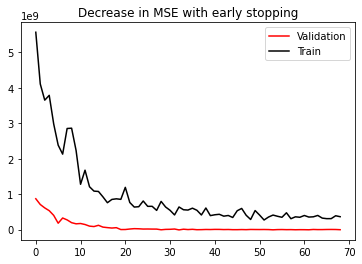

In [ ]:
plt.plot(range(69),reg.oob_improvement_,color="red",label="Validation")
plt.plot(range(69),reg.train_score_,color="k",label="Train")
plt.title("Decrease in MSE with early stopping")
plt.legend();

不难发现，袋外数据的设置可以帮助我们快速把握模型的迭代情况，在当前数据集上，设置大约50以下的迭代次数，就足够使用了。因此在我们对GBDT进行超参数调优时，我们也有了天然的`n_estimators`的范围设置。当然，当我们调整其他参数（如`learning_rate`或者`max_depth`）之后，`n_estimators`的范围可能受到影响，但我们已经有了50这个可以参考的点。

奇怪的是，袋外数据是天然的验证数据，而提前停止时需要使用验证集的功能，但sklearn中并未配置直接使用袋外数据来进行提前停止的功能。如果能够使用袋外数据进行提前停止，则可以使用更多数据进行训练，这将会更加有利于模型的学习。

|类型|参数|
|----|----|
|**弱评估器的训练数据**|参数：<br><br>&emsp;subsample：每次建树之前，从全数据集中进行有放回随机抽样的比例<br><br>&emsp;max_features：每次建树之前，从全特征中随机抽样特征进行分枝的比例<br><br>&emsp;random_state：随机数种子，控制整体随机模式<br><br>属性：<br><br>&emsp;<font color="green">**oob_improvement**</font>：每次建树之后相对于上一次袋外分数的增减<br><br>&emsp;<font color="green">**train_score_**</font>：每次建树之后相对于上一次验证时袋内分数的增减|

## 5 缺失的class_weight与n_jobs

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：n_estimators, learning_rate, <font color="green">**loss, alpha, init**</font><br>属性：<font color="green">**loss_, init_, estimators_**</font>|
|**弱评估器结构**|<font color="green">**criterion**</font>, max_depth, min_samples_split, min_samples_leaf, <br>min_weight_fraction_leaf, max_leaf_nodes,<br>min_impurity_decrease|
|**提前停止**|参数：<font color="green">**validation_fraction, n_iter_no_change, tol**</font><br>属性：<font color="green">**n_estimators_**</font>|
|**弱评估器的训练数据**|参数：subsample, max_features, random_state<br>属性：<font color="green">**oob_improvement, train_score_**</font>|
|**其他**|ccp_alpha, warm_start|

到这里，我们已经讲解完毕了梯度提升回归树以及梯度提升分类树中的所有参数。需要注意的是，作为最常用的集成算法之一，sklearn中的GBDT分类器并没有提供调节样本不均衡问题的参数class_weights，也不存在并行参数n_jobs。

不在样本不均衡问题上做文章，或许跟GBDT的弱评估器都是回归器有关，又或许是因为GBDT拥有非常强的学习能力，因此不会轻易被样本不均衡问题左右，也可能是因为sklearn在配置GBDT时存在一些失误。但务必要注意，如果样本存在严重不均衡的状况，那我们可能会考虑不使用梯度提升树，或者先对数据进行样本均衡的预处理后，再使用梯度提升树。

GBDT中的树必须一棵棵建立、且后面建立的树还必须依赖于之前建树的结果，因此GBDT很难在某种程度上实现并行，因此sklearn并没有提供n_jobs参数给Boosting算法使用。更加先进的Boosting算法们已经实现了分枝并行，但sklearn还无法实现这个功能，因此GBDT的计算速度难以得到加速，这是sklearn实现GBDT无法跨越的一个缺陷。